In [1]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg


In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.5 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import pandas as pd
import os
import duckdb as dd
import polars as pl
import h5py

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input/cafa-6-protein-function-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cafa-6-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-6-protein-function-prediction/IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo


In [ ]:
protein_accession_ids = []
protein_embeddings = []

with h5py.File("/kaggle/input/suman-uniprot-swissprot-embeds/per-protein.h5", "r") as file:
    print(f"number of entries: {len(file.keys())}")
    for sequence_id in file.keys():
        protein_accession_ids.append(sequence_id)
        embedding_data = file[sequence_id][()] 
        protein_embeddings.append(embedding_data)

emb_df = pd.DataFrame({
    'protein_accession_id': protein_accession_ids,
    'protein_embedding': protein_embeddings
})

emb_df.to_parquet('protein_embeddings.parquet')

In [5]:
emb_df = pl.read_parquet('/kaggle/input/suman-uniprot-swissprot-embeds/protein_embeddings.parquet')
emb_df.shape

(573650, 2)

In [6]:
emb_df.head(3)

protein_accession_id,protein_embedding
str,list[f32]
"""A0A009IHW8""","[0.068115, -0.046478, … -0.031021]"
"""A0A011QK89""","[0.003136, 0.023239, … 0.02655]"
"""A0A017SE81""","[0.013115, -0.029724, … 0.000838]"


In [7]:
dd.sql(" select count(distinct(protein_accession_id)) as proteins from emb_df ").pl()

proteins
i64
573650


In [8]:
train_terms_df = pl.read_csv('/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv', separator='\t')
train_terms_df.shape

(537027, 3)

In [9]:
train_terms_df.head(3)

EntryID,term,aspect
str,str,str
"""Q5W0B1""","""GO:0000785""","""C"""
"""Q5W0B1""","""GO:0004842""","""F"""
"""Q5W0B1""","""GO:0051865""","""P"""


In [10]:
dd.sql(" select count(distinct(EntryID)) as proteins from train_terms_df ").pl()

proteins
i64
82404


In [11]:
train_terms_w_embeds = dd.sql("select distinct t1.protein_accession_id, t2.term, t2.aspect, t1.protein_embedding \
from emb_df t1 \
join train_terms_df t2 \
on t1.protein_accession_id = t2.EntryID").pl()

train_terms_w_embeds.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(536906, 4)

In [12]:
train_terms_w_embeds.head(3)

protein_accession_id,term,aspect,protein_embedding
str,str,str,list[f32]
"""Q9UD71""","""GO:0007165""","""P""","[0.028595, -0.021408, … 0.049164]"
"""P91124""","""GO:0046928""","""P""","[-0.012222, -0.042236, … 0.005417]"
"""Q5XJA3""","""GO:0005794""","""C""","[0.023727, -0.009903, … -0.040955]"


In [13]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_w_embeds").pl()

uniq_protein_accession_ids
i64
82396


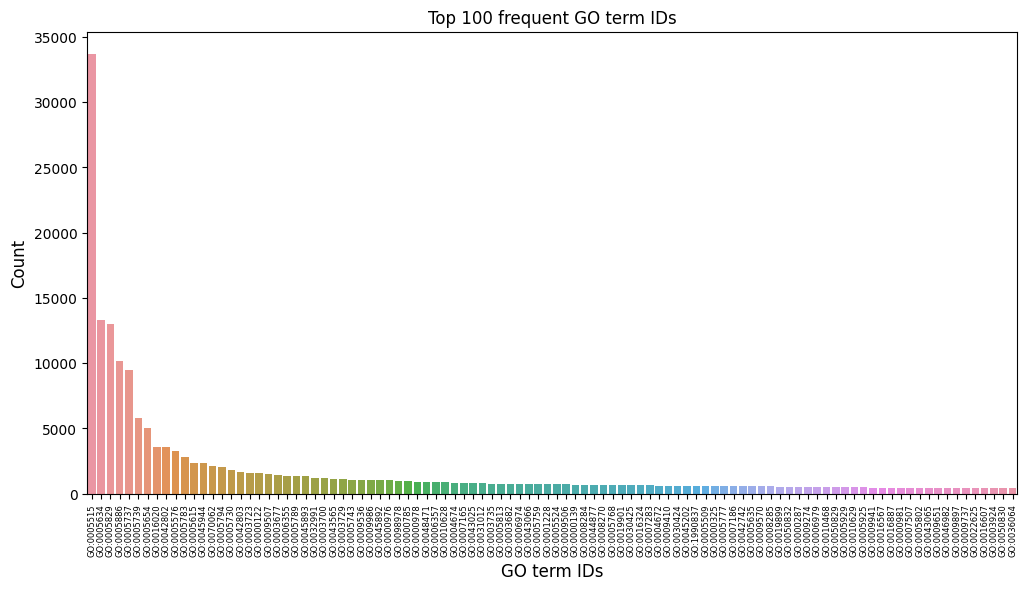

In [14]:
# Select first 1500 values for plotting
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [15]:
num_of_labels = 1500

query = "select term, count(1) as freq from train_terms_w_embeds group by term order by count(1) desc limit {0}".format(num_of_labels)

filtered_labels = dd.sql(query).pl()
labels_list = filtered_labels['term'].to_list()

# Take value counts in descending order and fetch first 3000 `GO term ID` as labels
train_labels = train_terms_w_embeds.filter(pl.col("term").is_in(labels_list))
train_labels.shape

(342029, 4)

In [16]:
train_labels.head(4)

protein_accession_id,term,aspect,protein_embedding
str,str,str,list[f32]
"""Q9UD71""","""GO:0007165""","""P""","[0.028595, -0.021408, … 0.049164]"
"""Q5XJA3""","""GO:0005794""","""C""","[0.023727, -0.009903, … -0.040955]"
"""P06781""","""GO:0031505""","""P""","[0.025681, 0.074646, … -0.018219]"
"""P06781""","""GO:0007264""","""P""","[0.025681, 0.074646, … -0.018219]"


In [17]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_labels").pl()

uniq_protein_accession_ids
i64
76298


In [18]:
train_protein_labels = train_labels.select(['protein_accession_id','term'])
train_protein_labels.head(5)

protein_accession_id,term
str,str
"""Q9UD71""","""GO:0007165"""
"""Q5XJA3""","""GO:0005794"""
"""P06781""","""GO:0031505"""
"""P06781""","""GO:0007264"""
"""P63321""","""GO:0003924"""


In [19]:
train_protein_labels_w_term_presence = train_protein_labels.with_columns(
    pl.lit(1.0).alias("presence")
)

pivoted_df = train_protein_labels_w_term_presence.pivot(
    index="protein_accession_id",
    on="term",
    values="presence",  
    aggregate_function="sum"
)

pivoted_df = pivoted_df.fill_null(0)

In [20]:
pivoted_df.head(5)

protein_accession_id,GO:0007165,GO:0005794,GO:0031505,GO:0007264,GO:0003924,GO:0005515,GO:0005739,GO:0045893,GO:0000139,GO:0042802,GO:0005737,GO:0004674,GO:0005886,GO:0045292,GO:0008021,GO:0000381,GO:0005654,GO:0045668,GO:0007417,GO:2000134,GO:0019731,GO:0005829,GO:0030175,GO:0031965,GO:0098978,GO:0000956,GO:0001533,GO:0000785,GO:0055085,GO:0009506,GO:0051056,GO:0005634,GO:0005667,GO:0005576,GO:0009986,GO:0031012,…,GO:0048839,GO:0032981,GO:0031463,GO:0009626,GO:0048527,GO:0046983,GO:0007033,GO:0010224,GO:0043495,GO:0048364,GO:0030864,GO:0035580,GO:0001707,GO:0001530,GO:0009741,GO:0045184,GO:0043068,GO:0000146,GO:0000151,GO:0001890,GO:0001891,GO:0019902,GO:0010218,GO:0019003,GO:0030855,GO:0007298,GO:0030476,GO:0007596,GO:0017025,GO:0042832,GO:0035050,GO:0046329,GO:0060326,GO:0055074,GO:0006513,GO:0050769,GO:0006906
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Q9UD71""",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q5XJA3""",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P06781""",0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P63321""",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P14737""",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pivoted_df.shape

(76298, 1501)

In [21]:
train_protein_features = dd.sql("select distinct protein_accession_id, protein_embedding \
from train_labels").pl()

train_protein_features.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

protein_accession_id,protein_embedding
str,list[f32]
"""P0ABL1""","[0.0215, 0.002981, … 0.05365]"
"""P0CH09""","[0.074341, 0.130371, … 0.06781]"
"""Q99207""","[-0.003675, -0.076599, … 0.039703]"
"""P63027""","[0.062866, 0.109802, … 0.011276]"
"""Q7ZZY3""","[0.013367, -0.061676, … 0.01046]"


In [22]:
train_protein_features_flattened = train_protein_features.with_columns(
    # Convert the list to a struct, which gives anonymous field names like 'field_0', 'field_1', etc.
    pl.col("protein_embedding").list.to_struct()
).unnest(
    # Unnest the 'protein_embedding' struct column into individual columns
    "protein_embedding"
)

train_protein_features_flattened.shape

/tmp/ipykernel_39/2367105210.py:3: UserWarning: `to_struct()` should be passed a list of field names to avoid query errors in subsequent operations (e.g. <struct operation> not supported for dtype Unknown)
  pl.col("protein_embedding").list.to_struct()


(76298, 1025)

In [23]:
train_protein_features_flattened.head(5)

protein_accession_id,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,…,field_987,field_988,field_989,field_990,field_991,field_992,field_993,field_994,field_995,field_996,field_997,field_998,field_999,field_1000,field_1001,field_1002,field_1003,field_1004,field_1005,field_1006,field_1007,field_1008,field_1009,field_1010,field_1011,field_1012,field_1013,field_1014,field_1015,field_1016,field_1017,field_1018,field_1019,field_1020,field_1021,field_1022,field_1023
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""P0ABL1""",0.0215,0.002981,0.070618,0.066833,0.004581,0.054504,0.036713,-0.024323,0.004524,0.013641,-0.020737,-0.039001,-0.021545,-0.040588,-0.029861,-0.009529,-0.040924,0.065613,0.08667,-0.010864,0.010506,0.040741,-0.054382,0.060974,-0.048248,-0.069397,-0.015038,-0.005241,-0.043274,0.019852,-0.010925,0.077454,-0.134033,-0.005257,-0.122314,0.064941,…,0.025162,-0.014488,0.0121,-0.006489,-0.004833,0.049652,0.008324,0.020187,-0.047821,0.023788,-0.021576,0.015297,0.029037,0.067383,0.019379,-0.010277,-0.015152,0.123291,-0.043701,0.036774,0.058929,-0.012451,-0.005829,-0.083313,-0.032135,0.079834,-0.086304,-0.05307,-0.053955,-0.016479,-0.06192,0.043396,-0.010155,-0.051697,0.01886,0.012039,0.05365
"""P0CH09""",0.074341,0.130371,-0.005749,-0.019379,0.045746,0.015343,0.026337,-0.170776,-0.138184,-0.02861,-0.087341,0.03891,-0.051422,0.03241,0.095093,0.063049,0.048004,-0.098938,-0.067688,-0.065063,-0.018936,-0.048157,0.064209,-0.061584,-0.101624,0.013145,0.082092,-0.0578,0.041779,0.013489,0.047028,0.044403,-0.092529,-0.131958,-0.114258,-0.102844,…,-0.019394,0.055511,-0.01857,-0.019409,-0.067139,0.087036,-0.044983,0.085205,-0.03241,-0.016098,-0.005814,0.151367,-0.034546,0.019241,-0.080322,-0.151001,0.009575,0.122742,-0.045288,0.160767,0.058685,0.027008,-0.147461,-0.05542,-0.050873,0.12561,0.069336,-0.040344,-0.009697,-0.119263,-0.121094,0.037415,-0.092041,-0.031738,-0.064087,0.014984,0.06781
"""Q99207""",-0.003675,-0.076599,-0.003843,0.047333,0.000852,-0.011559,0.003431,-0.105286,0.03093,0.019165,-0.05954,-0.000543,0.0234375,0.000686,-0.005997,0.031464,0.002831,0.026031,0.050354,0.029495,-0.062866,-0.015869,-0.011459,-0.01432,-0.064575,-0.037628,-0.044373,-0.03537,-0.00742,0.031464,-0.008591,0.00658,-0.139526,0.005581,-0.113892,0.02832,…,0.000322,-0.016235,-0.018463,-0.009186,0.002672,-0.016632,0.002501,-0.00433,-0.001052,-0.019852,0.017822,0.009354,-0.057129,0.035858,-0.024231,0.027145,-0.004189,0.111267,0.013756,0.033783,0.00639,0.058289,-0.058441,0.034027,-0.047089,-0.024124,-0.063538,-0.077698,-0.037659,-0.013,0.032379,0.023117,0.039246,-0.018158,0.004803,-0.018402,0.039703
"""P63027""",0.062866,0.109802,0.071655,-0.00321,0.021805,0.052948,-0.00147,-0.113586,-0.099854,-0.069824,-0.036743,0.022995,0.000994,0.027328,0.045776,0.027466,0.050781,-0.055542,-0.070679,0.032593,-0.058228,-0.035248,0.052399,-0.029129,0.016296,0.003677,0.105164,-0.004269,0.013145,-0.01535,0.012268,0.131226,-0.118042,-0.066711,-0.119629,0.000219,…,-0.010254,0.000602,0.017776,-0.004345,-0.025696,0.05481,0.03183,0.026917,-0.087891,0.067688,-0.070923,0.06366,-0.139282,0.022385,0.061401,-0.07312,-0.013474,0.131104,-0.062988,0.063171,0.031372,-0.03421,-0.063354,0.018219,-0.030396,0.007935,0.016525,-0.074768,-0.05542,-0.064575,0.017746,-0.01046,-0.02887,-0.043793,0.039459,0.005814,0.011276
"""Q7ZZY3""",0.013367,-0.061676,0.065247,0.039581,-0.003506,0.017181,-0.035095,-0.078857,0.006355,0.030914,-0.027054,-0.061249,-0.00387,-0.003132,-0.005417,-0.008041,0.0197

In [25]:
pivoted_df.write_parquet('train_protein_labels.parquet')
train_protein_features_flattened.write_parquet('train_protein_features.parquet')

In [26]:
test_prot_ids = [seq_record.id 
                 for seq_record in 
                 SeqIO.parse("/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta", "fasta")]

In [27]:
test_embeds = emb_df.filter(pl.col("protein_accession_id").is_in(test_prot_ids))
test_embeds.shape

(224298, 2)

In [28]:
test_embeds.head(4)

protein_accession_id,protein_embedding
str,list[f32]
"""A0A017SE81""","[0.013115, -0.029724, … 0.000838]"
"""A0A017SE85""","[-0.021576, -0.013786, … -0.001319]"
"""A0A017SEF3""","[0.030869, -0.130371, … -0.000622]"
"""A0A017SEX7""","[0.025375, -0.009087, … -0.003748]"


In [29]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from test_embeds").pl()

uniq_protein_accession_ids
i64
224298


In [30]:
test_protein_features_flattened = test_embeds.with_columns(
    # Convert the list to a struct, which gives anonymous field names like 'field_0', 'field_1', etc.
    pl.col("protein_embedding").list.to_struct()
).unnest(
    # Unnest the 'protein_embedding' struct column into individual columns
    "protein_embedding"
)

test_protein_features_flattened.shape

/tmp/ipykernel_39/1620949314.py:3: UserWarning: `to_struct()` should be passed a list of field names to avoid query errors in subsequent operations (e.g. <struct operation> not supported for dtype Unknown)
  pl.col("protein_embedding").list.to_struct()


(224298, 1025)

In [31]:
test_protein_features_flattened.write_parquet('test_protein_features.parquet')